<a href="https://colab.research.google.com/github/anqi-guo/duplicated_complaints_identification/blob/main/4_sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

path = '/content/drive/My Drive/work/重复线索识别/data/labeled_data'

df = pd.read_excel(f'{path}/final_data.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df['label'].value_counts()

0.0    10568
1.0     2097
Name: label, dtype: int64

In [ ]:
# downsample non-duplicated data
df_dup = df[df['label']==1]

df_nondup = df[df['label']==0]
df_nondup_downsampled = df_nondup.sample(df_dup.shape[0])

df_balanced = pd.concat([df_dup, df_nondup_downsampled])

df_balanced['label'].value_counts()

1.0    1765
0.0    1765
Name: label, dtype: int64

In [7]:
# split data into train, val, and test
train_list = []
val_list = []
test_list = []
for i in range(2):
  data = df[df['label']==i]

  train_data = data.sample(frac=.9, random_state=0)
  train_list.append(train_data)

  temp_data = pd.concat([data, train_data]).drop_duplicates(keep=False)
  val_data = temp_data.sample(frac=.5, random_state=0)
  val_list.append(val_data)

  test_data = pd.concat([temp_data, val_data]).drop_duplicates(keep=False)
  test_list.append(test_data)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)

train_df.shape, val_df.shape, test_df.shape

((11398, 3), (633, 3), (634, 3))

In [8]:
! pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 3.8 MB 25.2 MB/s 
     |████████████████████████████████| 1.2 MB 58.3 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 66.7 MB/s 
     |████████████████████████████████| 895 kB 72.2 MB/s 
     |████████████████████████████████| 596 kB 89.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=25ec0c3ea52e44ef1c94e341164570b344a3f5aa3fccab8519d017ce3a6e4df4
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [9]:
from sentence_transformers import models, SentenceTransformer, util
import torch.nn as nn

#MODEL_NAME = 'imxly/sentence_rtb3'
#MODEL_NAME = 'uer/sbert-base-chinese-nli'
MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
MAX_SEQ_LENGTH = 128
OUT_FEATURES_DIM = 256

word_embedding_model = models.Transformer(MODEL_NAME, max_seq_length=MAX_SEQ_LENGTH)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode_mean_tokens=True, pooling_mode_cls_token=False, pooling_mode_max_tokens=False)
#dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=OUT_FEATURES_DIM, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[
                                     word_embedding_model, 
                                     pooling_model, 
                                     #dense_model
                                     ])

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/449M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

# test set prediction before fine-tuning

  0%|          | 0/634 [00:00<?, ?it/s]

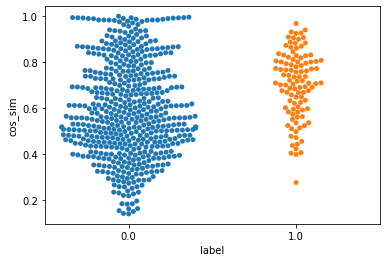

In [10]:
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

test_df['cos_sim'] = test_df.progress_apply(lambda row: util.pytorch_cos_sim(model.encode(row['sentence1']), model.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.swarmplot(data=test_df, y='cos_sim', x='label')

# fine-tune model

In [11]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, evaluation, losses, models, util
from torch.utils.data import DataLoader
import torch.nn as nn

#model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# define train examples
train_data = []
for idx, row in train_df.iterrows():
  train_data.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label']))

# define evaluation examples
sentences1 = val_df['sentence1'].tolist()
sentences2 = val_df['sentence2'].tolist()
labels = val_df['label'].tolist()
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, labels)

# define train dataset, the dataloader and the train loss
train_dataset = SentencesDataset(train_data, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(model=model)


model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=10, 
          warmup_steps=100, 
          evaluator=evaluator, 
          evaluation_steps=10, 
          output_path='/content/drive/My Drive/work/重复线索识别/models/sb')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration:   0%|          | 0/357 [00:00<?, ?it/s]

# test set prediction after fine-tuning

  0%|          | 0/634 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


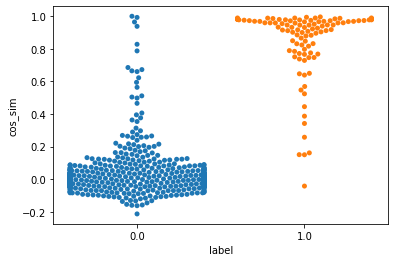

In [12]:
test_df['cos_sim'] = test_df.progress_apply(lambda row: util.cos_sim(model.encode(row['sentence1']), model.encode(row['sentence2'])).item(), axis=1)
test_df['label'] = test_df['label'].astype(str)
sns.swarmplot(data=test_df, y='cos_sim', x='label')

In [14]:
test_df.query('label=="0.0" and cos_sim>.5')

,label,sentence1,sentence2,cos_sim
0,0.0,朝阳路安路叉口关城小区拖运渣土污染末清理冲洗,朝阳路安路交叉口关城花苑大面积黄土裸露未覆盖,0.660524
1901,0.0,DH金湖县金街道洪圩村马圩组齐红兰音家现违规生产气味扰民来电希望解决气味扰民问题金街道来电反...,金湖县金街道每天之后金菜市场里会刺耳声音,0.672664
2063,0.0,金街道洪圩村港组号其家门前向阳闸七方港水域区内杂草丛生垃圾遍地,金湖县金街道洪圩村港组号附近杂草堆放路边希望及时清理,0.828064
2330,0.0,涟水梁岔镇红码村王庄组修建养鸡场核实工单DH梁岔镇回复调查发现目前养鸡场尚未建成并未投入使用...,淮安综合频道淮安新闻联播第期涟水梁岔镇薛元村周徐组仕海家庭农场大量鸡粪暂存场内未及时清运粪棚...,0.665074
5225,0.0,永怀路永怀路门大街交口路侧永怀路金鹏饭店正油烟污染,永怀路永怀路门大街交口路侧同安堂药房墙上油污地图有误,0.787355
5562,0.0,梁红玉路梁红玉路华路交口路侧梁红玉路优品意佳装饰工程专家绿地里焚烧纸灰,梁红玉路梁红玉路中心路交口路侧梁红玉路翡翠装潢正油烟污染,0.685498
6177,0.0,接口清江浦区徐家湖路号徐家湖路歌舞厅刚开业音乐声音太市民来电希望协调降低噪音回电市民表示公安...,清江华府新民路徐家湖路交叉口一家糕师祖蛋糕店昨天一直音响播放音乐声音很大噪音扰民希望禁止噪音扰民,0.964879
6326,0.0,清江华府市民清江华府小区号楼B单元饭店门面每天凌晨点左右机器噪音影响市民休息来电希望解决噪音问题,新民路清江华府门面老尹烤肉每天晚间以后桌椅炉子摆放店铺门口经营食客说话声音噪音扰民处处理意见...,0.504261
7019,0.0,融侨华府侧工地夜间施工噪音扰民来电希望禁止夜间施工噪音扰民,融侨华府期工地近期每天施工噪音扰民严重来电希望部门尽快解决施工噪音问题,0.992805
7298,0.0,亿力未来城期业主区内水立方洗浴中心经常发出滴滴噪音来电希望协调禁止噪音扰民,亿力未来城一期靠近臧家码头亿力未来城一期方向污水直接排放里运河水韵天成靠近越秀桥桥附近污水直...,0.563981
